# A/B Тестирование. Учебный проект.




In [ ]:
import numpy as np
import scipy.stats as st
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

## A/B тест онлайн-бизнеса электронной коммерции

Вы работаете в команде разработчиков **онлайн-бизнеса электронной коммерции**. UX-дизайнер очень усердно работал над новой версией страницы продукта в надежде, что это приведет к более высокому коэффициенту конверсии. Менеджер по продукту сказал вам, что **текущий коэффициент конверсии** составляет около **12%** в среднем в течение года и что команда была бы рада **увеличению на 2%**, что означает, что новый дизайн будет считаться успешным, если он поднимет коэффициент конверсии до 14%.

Прежде чем внедрять изменение, команде было бы удобнее протестировать его на небольшом количестве пользователей, чтобы увидеть, как оно работает, поэтому вы предлагаете провести **A/B-тест** на подмножестве пользователей вашей пользовательской базы.

### 1. Планирование эксперимента

Прежде всего, необходимо сформулировать нулевую гипотезу, чтобы не ошибиться при интерпретации результатов.

Поскольку мы не знаем, будет ли новый дизайн работать лучше или хуже, или будет таким же, как наш текущий дизайн, мы выберем <a href="https://en.wikipedia.org/wiki/One-_and_two-tailed_tests">**двусторонний тест**</a>:

$$H_0: p = p_0$$
$$H_a: p \ne p_0$$

где $p$ и $p_0$ — коэффициент конверсии нового и старого дизайна соответственно. Мы также установим **уровень достоверности 95%**:

$$\alpha = 0,05$$

### 2. Сбор и подготовка данных

У нас есть **290583 строк**, каждая из которых представляет сеанс пользователя, а также **5 столбцов**:
* `user_id` - идентификатор пользователя каждой сессии
* `timestamp` - Отметка времени сеанса
* `group` — к какой группе был отнесен пользователь для этого сеанса {`control`, `treatment`}
* `converted` - закончился ли сеанс конверсией или нет (двоичный, `0`=не преобразовано, `1`=конвертировано)

Мы будем использовать для анализа только столбцы «group» и «converted».

In [ ]:
df = pd.read_csv('drive/MyDrive/ab_data.csv')
df.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [ ]:
df.groupby('group')['converted'].count()

,converted
group,
A,145241
B,145241




Прежде чем мы приступим к выборке данных для получения нашего подмножества, давайте удостоверимся, что нет пользователей, которые были отобраны несколько раз.

In [ ]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'В нашем наборе данных присутствует {multi_users} повторений пользователей по ID')

В нашем наборе данных присутствует 1896 повторений пользователей по ID


### 3. Расчет конверсии

In [ ]:
conversion_rates = df.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: st.sem(x, ddof=0)            # (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['конверсия', 'сред. кв. отклонение', 'ошибка среднего']


conversion_rates

<ipython-input-81-4290ce5abb8f>:6: FutureWarning: The provided callable <function mean at 0x7b5b50ef7d90> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])


,конверсия,сред. кв. отклонение,ошибка среднего
group,,,
A,0.120262,0.325268,0.000853
B,0.118685,0.323418,0.000849


Судя по приведенной выше статистике, похоже, что **наши два проекта работали очень похоже**, а наш новый дизайн работал немного хуже - **коэффициент конверсии 11,9% против 12%**.

 **Является ли эта разница *статистически значимой***?

### 4. Проверка гипотезы

Последним шагом нашего анализа является проверка нашей гипотезы. Так как у нас очень большая выборка, мы можем использовать <a href="https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Normal_ приблизительно_interval">нормальное приближение</a> для расчета нашего значения $p$ (т.е. z-тест).

Опять же, Python делает все вычисления очень простыми. Мы можем использовать модуль `statsmodels.stats.proportion`, чтобы получить значение $p$ и доверительные интервалы:

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
control_results = df[df['group'] == 'A']['converted']
treatment_results = df[df['group'] == 'B']['converted']

In [ ]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z-статистика: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ДИ 95% для контрольной группы: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ДИ 95% для тестовой группы: [{lower_treat:.3f}, {upper_treat:.3f}]');

z-статистика: 1.31
p-value: 0.190
ДИ 95% для контрольной группы: [0.119, 0.122]
ДИ 95% для тестовой группы: [0.117, 0.120]


### 5. Выводы

Поскольку наше значение $p=0.19$ намного превышает наше значение $\alpha=0.05$, мы не можем отвергнуть нулевую гипотезу $H_0$, а это означает, что наш новый дизайн не имел существенных отличий (не говоря уже о лучшем) от нашего старого. :(

Кроме того, если мы посмотрим на доверительный интервал для тестовой группы ( [0.117, 0.120]), то заметим, что:
1. Он включает наше базовое значение коэффициента конверсии $12\%$.
2. Он не включает наше целевое значение в $14\%$ ($2\%$ роста, к которому мы стремились).

Это означает, что более вероятно, что истинный коэффициент конверсии нового дизайна будет похож на наш базовый уровень, а не на целевые 14%, на которые мы надеялись. Это еще одно доказательство того, что наш новый дизайн вряд ли будет улучшением нашего старого дизайна!

## A/B тест. Сравнение эффетиквности стратегий в онлайн магазине

Компания представила новую стратегию рекомендаций для своего онлайн магазина. Было решено провести A/B тест для сравнения эффективности новой стратегии с предыдущей. Тест выполнялся в течение одного месяца, были собранны данные от 30 клиентов по каждой стратегии и теперь их необходимо проанализировать.

#### Импорт данных

In [ ]:
df_control = pd.read_csv('https://raw.githubusercontent.com/obulygin/content/main/ab_test/control_group.csv', sep = ";")
df_control.head()

,Name,Date,Spent [USD],# of Impressions,Reach,# of Clicks,# of Searches,# of Views,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для удобства можно переименовать столбцы

In [ ]:
df_control.rename(columns = {'Name':'Имя', 'Date': 'Дата','Spent [USD]': 'Расход USD',\
                             '# of Impressions':'Кол-во показов','Reach':'Охват','# of Clicks':'Кол-во кликов',\
                             '# of Searches':'Кол-во запросов','# of Views':'Кол-во просмотров',
                             '# of Add to Cart':'В корзине','# of Purchase':'Кол-во покупок'}, inplace = True)

In [ ]:
df_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Имя                30 non-null     object 
 1   Дата               30 non-null     object 
 2   Расход USD         30 non-null     int64  
 3   Кол-во показов     29 non-null     float64
 4   Охват              29 non-null     float64
 5   Кол-во кликов      29 non-null     float64
 6   Кол-во запросов    29 non-null     float64
 7   Кол-во просмотров  29 non-null     float64
 8   В корзине          29 non-null     float64
 9   Кол-во покупок     29 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ KB


In [ ]:
df_test = pd.read_csv('https://raw.githubusercontent.com/obulygin/content/main/ab_test/test_group.csv', sep = ";")
df_test.head()

,Name,Date,Spent [USD],# of Impressions,Reach,# of Clicks,# of Searches,# of Views,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [ ]:
df_test.rename(columns = {'Name':'Имя', 'Date': 'Дата','Spent [USD]': 'Расход USD',\
                             '# of Impressions':'Кол-во показов','Reach':'Охват','# of Clicks':'Кол-во кликов',\
                             '# of Searches':'Кол-во запросов','# of Views':'Кол-во просмотров',
                             '# of Add to Cart':'В корзине','# of Purchase':'Кол-во покупок'}, inplace = True)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Имя                30 non-null     object
 1   Дата               30 non-null     object
 2   Расход USD         30 non-null     int64 
 3   Кол-во показов     30 non-null     int64 
 4   Охват              30 non-null     int64 
 5   Кол-во кликов      30 non-null     int64 
 6   Кол-во запросов    30 non-null     int64 
 7   Кол-во просмотров  30 non-null     int64 
 8   В корзине          30 non-null     int64 
 9   Кол-во покупок     30 non-null     int64 
dtypes: int64(8), object(2)
memory usage: 2.5+ KB


#### Обработка пропусков в данных

1. Если пропусков мало, то такие строки можно просто удалить

In [ ]:
df_drop = df_control.dropna().reset_index(drop = True)

In [ ]:
df_drop.describe()

,Расход USD,Кол-во показов,Охват,Кол-во кликов,Кол-во запросов,Кол-во просмотров,В корзине,Кол-во покупок
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,2304.068966,109559.758621,88844.931034,5320.793103,2221.310345,1943.793103,1300.000000,522.793103
std,363.534822,21688.922908,21832.349595,1757.369003,866.089368,777.545469,407.457973,185.028642
min,1757.000000,71274.000000,42859.000000,2277.000000,1001.000000,848.000000,442.000000,222.000000
25%,1962.000000,92029.000000,74192.000000,4085.000000,1615.000000,1249.000000,930.000000,372.000000
50%,2319.000000,113430.000000,91579.000000,5224.000000,2390.000000,1984.000000,1339.000000,501.000000
75%,2544.000000,121332.000000,102479.000000,6628.000000,2711.000000,2421.000000,1641.000000,670.000000
max,3083.000000,145248.000000,127852.000000,8137.000000,4891.000000,4219.000000,1913.000000,800.000000


In [ ]:
df_control.isnull().sum()

,0
Имя,0
Дата,0
Расход USD,0
Кол-во показов,1
Охват,1
Кол-во кликов,1
Кол-во запросов,1
Кол-во просмотров,1
В корзине,1
Кол-во покупок,1


2. Но если данных мало, то стоит поискать альтернативные варианты - например, заполнение похожими значениями

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
imputer = KNNImputer()

In [ ]:
df_control.iloc[:,2:10] = pd.DataFrame(imputer.fit_transform(df_control.iloc[:,2:10]))

In [ ]:
df_control.isnull().sum()

,0
Имя,0
Дата,0
Расход USD,0
Кол-во показов,0
Охват,0
Кол-во кликов,0
Кол-во запросов,0
Кол-во просмотров,0
В корзине,0
Кол-во покупок,0


In [ ]:
df_control.describe()

,Расход USD,Кол-во показов,Охват,Кол-во кликов,Кол-во запросов,Кол-во просмотров,В корзине,Кол-во покупок
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2288.433333,109186.486667,88498.280000,5335.500000,2218.520000,1943.366667,1300.466667,524.553333
std,367.334451,21409.538119,21536.486222,1728.681554,851.163019,764.025477,400.379366,182.065958
min,1757.000000,71274.000000,42859.000000,2277.000000,1001.000000,848.000000,442.000000,222.000000
25%,1945.500000,93612.150000,75255.350000,4122.250000,1629.250000,1249.000000,942.500000,375.500000
50%,2299.500000,112368.000000,91418.000000,5329.500000,2340.000000,1979.500000,1326.500000,506.000000
75%,2532.000000,121259.000000,101958.750000,6609.500000,2655.000000,2360.500000,1638.000000,663.250000
max,3083.000000,145248.000000,127852.000000,8137.000000,4891.000000,4219.000000,1913.000000,800.000000


#### Подготовка данных к анализу

Объединим данные в один фрейм и рассчитаем несколько ключевых характеристик

In [ ]:
df = pd.concat([df_test,df_control])
df = df.reset_index()

df['USD за покупку'] = round(df['Расход USD']/df['Кол-во покупок'],2)

df['CTR(%)'] = round(df['Кол-во кликов']*100/df['Кол-во показов'],2)

df['Конверсия(%)'] = round(df['Кол-во покупок']*100/df['Кол-во кликов'],2)

df.head()

,index,Имя,Дата,Расход USD,Кол-во показов,Охват,Кол-во кликов,Кол-во запросов,Кол-во просмотров,В корзине,Кол-во покупок,USD за покупку,CTR(%),Конверсия(%)
0,0,Test Campaign,1.08.2019,3008.0,39550.0,35820.0,3038.0,1946.0,1069.0,894.0,255.0,11.80,7.68,8.39
1,1,Test Campaign,2.08.2019,2542.0,100719.0,91236.0,4657.0,2359.0,1548.0,879.0,677.0,3.75,4.62,14.54
2,2,Test Campaign,3.08.2019,2365.0,70263.0,45198.0,7885.0,2572.0,2367.0,1268.0,578.0,4.09,11.22,7.33
3,3,Test Campaign,4.08.2019,2710.0,78451.0,25937.0,4216.0,2216.0,1437.0,566.0,340.0,7.97,5.37,8.06
4,4,Test Campaign,5.08.2019,2297.0,114295.0,95138.0,5863.0,2106.0,858.0,956.0,768.0,2.99,5.13,13.10


In [ ]:
df = df.drop(['index'], axis=1)

#### Визуализация данных

Целью данного этапа яявляется проверка адекватности собранных данных, а также выявление идей для дальнейшего анализа

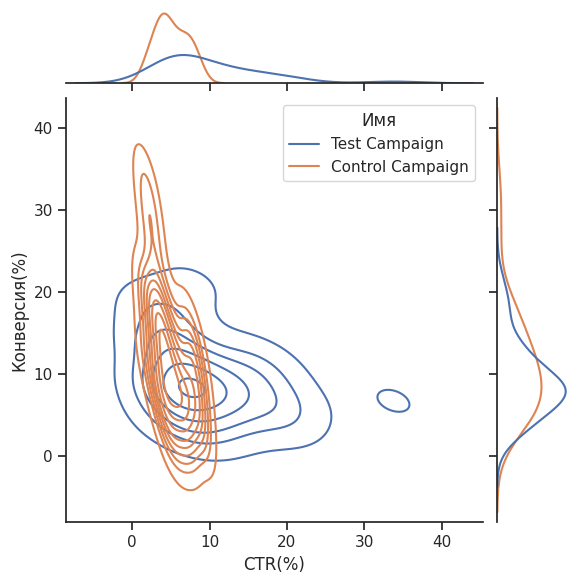

In [ ]:
sns.set_theme(style="ticks")
g = sns.jointplot(
    data=df,
    x="CTR(%)", y="Конверсия(%)", hue="Имя",
    kind="kde",
)
plt.show()

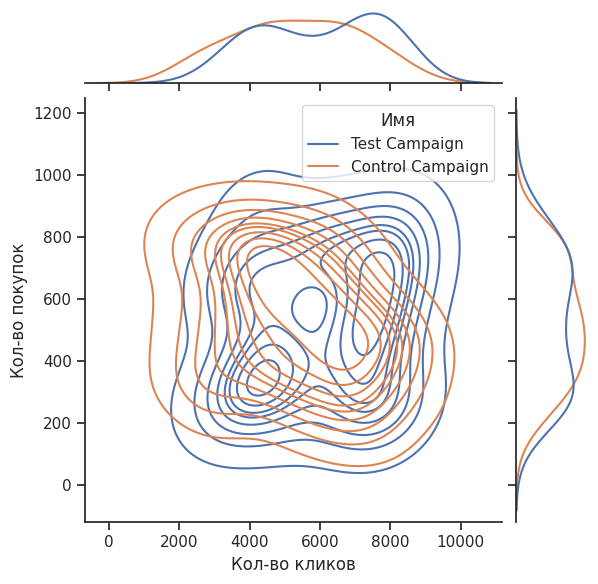

In [ ]:
sns.set_theme(style="ticks")
g = sns.jointplot(
    data=df,
    x="Кол-во кликов", y="Кол-во покупок", hue="Имя",
    kind="kde",
)
plt.show()

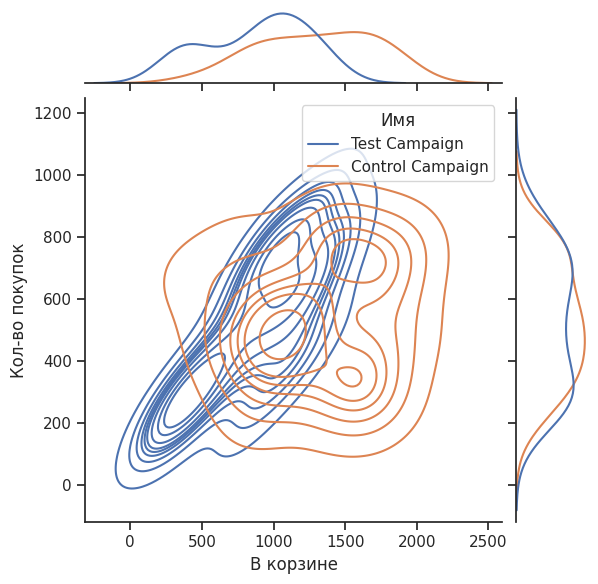

In [ ]:
sns.set_theme(style="ticks")
g = sns.jointplot(
    data=df,
    x="В корзине", y="Кол-во покупок", hue="Имя",
    kind="kde",
)
plt.show()

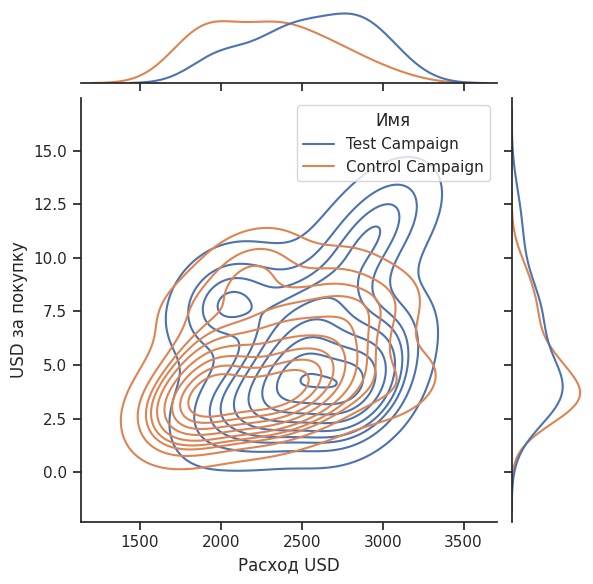

In [ ]:
sns.set_theme(style="ticks")
g = sns.jointplot(
    data=df,
    x="Расход USD", y="USD за покупку", hue="Имя",
    kind="kde",
)
plt.show()

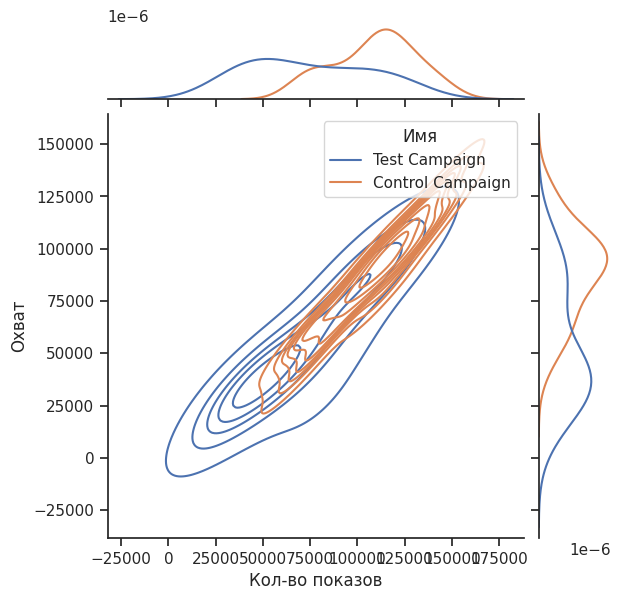

In [ ]:
sns.set_theme(style="ticks")
g = sns.jointplot(
    data=df,
    x="Кол-во показов", y="Охват", hue="Имя",
    kind="kde",
)
plt.show()

#### Проверка гипотез

<b>Идея 1.</b> Проверка новой и старой кампаний на предмет эффективности расходов.

In [ ]:
total_spend = df.groupby(['Имя'])['Расход USD'].sum().reset_index()
total_spend

,Имя,Расход USD
0,Control Campaign,68653.0
1,Test Campaign,76892.0


In [ ]:
spend_per_purchase = df.groupby(['Имя'])['USD за покупку'].mean().reset_index()
spend_per_purchase

,Имя,USD за покупку
0,Control Campaign,4.990667
1,Test Campaign,5.900000


Из цифр видно, что тестовая компания требует больших расходов, но является ли эта разница статистически значимой или скорее случайной?
Чтобы ответить на этот вопрос, проведем статистический тест.

Для начала определимся с распределением данных

In [ ]:
data_1 = df.loc[df['Имя']=='Control Campaign']['USD за покупку'].values
data_2 = df.loc[df['Имя']=='Test Campaign']['USD за покупку'].values

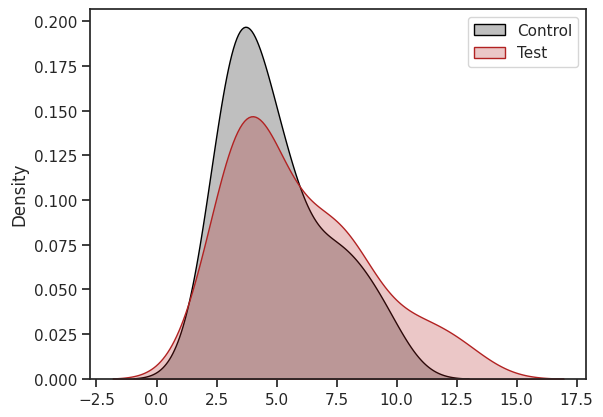

In [ ]:
sns.kdeplot(data_1, label="Control", fill = True, color = '#000000')
sns.kdeplot(data_2, label="Test", fill = True, color = '#B22222')
plt.legend()
plt.show()

In [ ]:
stat, p = st.shapiro(data_1)

print(f'stat = {stat:.3f}, p = {p:.5f}')
if p > 0.05:
    print('Вероятно нормальное распределение')
else:
    print('Вероятно не нормальное распределение')

stat = 0.905, p = 0.01117
Вероятно не нормальное распределение


In [ ]:
stat, p = st.shapiro(data_2)

print(f'stat = {stat:.3f}, p = {p:.5f}')
if p > 0.05:
    print('Вероятно нормальное распределение')
else:
    print('Вероятно не нормальное распределение')

stat = 0.896, p = 0.00689
Вероятно не нормальное распределение


Распределение ненормальное, поэтому будем использовать критерий Манна-Уитни

In [ ]:
stat, p = st.mannwhitneyu(data_1, data_2)

print(f"Статистика = {stat:.5f}, p = {p:.5f}")

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, разницы, вероятно, нет')
else:
    print('Отклоняем нулевую гипотезу, разница, вероятно, есть')

Статистика = 367.00000, p = 0.22255
Не отклоняем нулевую гипотезу, разницы, вероятно, нет


<b>Вывод.</b> Тест не показал наличие статистически значимой разницы в расходах - при текущих данных мы не можем утверждать, что тестовая компания будет обходится нам дороже.

<b>Идея 2.</b> Проверка новой и старой кампаний на предмет увеличения числа покупок.

In [ ]:
num_of_purchase = df.groupby(['Имя'])['Кол-во покупок'].sum().reset_index()
num_of_purchase

,Имя,Кол-во покупок
0,Control Campaign,15736.6
1,Test Campaign,15637.0


Цифры показывают незначительное падение продаж для новой кампании, но является ли оно статистически значимым?

In [ ]:
data_1 = df.loc[df['Имя']=='Control Campaign']['Кол-во покупок'].values
data_2 = df.loc[df['Имя']=='Test Campaign']['Кол-во покупок'].values

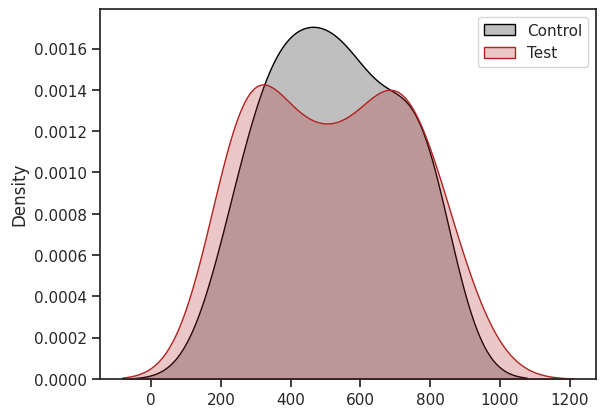

In [ ]:
sns.kdeplot(data_1, label="Control", fill = True, color = '#000000')
sns.kdeplot(data_2, label="Test", fill = True, color = '#B22222')
plt.legend()
plt.show()

In [ ]:
stat, p = st.shapiro(data_1)

print(f"Статистика = {stat:.5f}, p = {p:.5f}")
if p > 0.05:
    print('Вероятно нормальное распределение')
else:
    print('Вероятно не нормальное распределение')

Статистика = 0.94406, p = 0.11700
Вероятно нормальное распределение


In [ ]:
stat, p = st.shapiro(data_2)

print(f"Статистика = {stat:.5f}, p = {p:.5f}")
if p > 0.05:
    print('Вероятно нормальное распределение')
else:
    print('Вероятно не нормальное распределение')

Статистика = 0.91819, p = 0.02408
Вероятно не нормальное распределение


Распределение ненормальное, поэтому будем использовать критерий Манна-Уитни

In [ ]:
stat, p = st.mannwhitneyu(data_1, data_2)

print(f"Статистика = {stat:.5f}, p = {p:.5f}")

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые')
else:
    print('Отклоняем нулевую гипотезу, распределения, вероятно, различаются')

Статистика = 456.00000, p = 0.93519
Не отклоняем нулевую гипотезу, распределения, вероятно, одинаковые


<b>Вывод.</b> Тест не показал наличие статистически значимой разницы в продажах - при текущих данных мы не можем утверждать, что тестовая компания уменьшает или увеличивает продажи.

<b>Идея 3.</b> Проверка новой и старой кампаний на предмет увеличения конверсии клиентов.

In [ ]:
df_2 = df.copy()
df_2 = df_2.drop(['Дата'], axis=1)
df_2['Имя'] = pd.get_dummies(df_2['Имя'], drop_first=True)
df_2 = df_2.reset_index(drop=True)
test_g = df_2[df_2['Имя']==1]
control_g = df_2[df_2['Имя']==0]

In [ ]:
test_group = test_g['Конверсия(%)']
test_group.describe()

,Конверсия(%)
count,30.000000
mean,9.230667
std,4.449266
min,3.010000
25%,6.570000
50%,8.450000
75%,11.667500
max,21.090000


In [ ]:
control_group = control_g['Конверсия(%)']
control_group.describe()

,Конверсия(%)
count,30.000000
mean,11.428000
std,6.725037
min,3.350000
25%,6.315000
50%,10.110000
75%,14.365000
max,32.240000


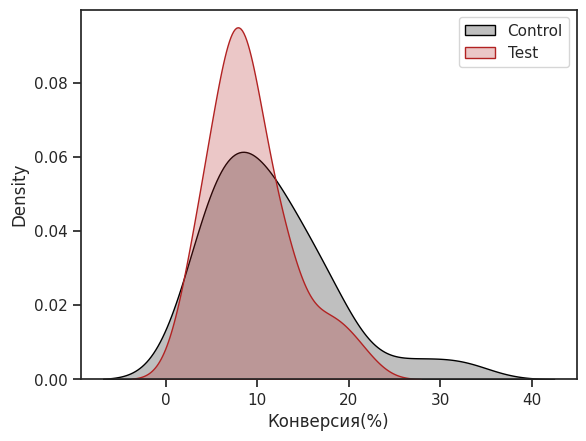

In [ ]:
sns.kdeplot(control_group, label="Control", fill = True, color = '#000000')
sns.kdeplot(test_group, label="Test", fill = True, color = '#B22222')
plt.legend()
plt.show()

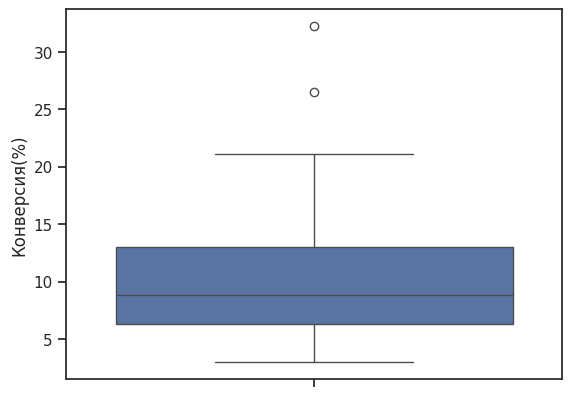

In [ ]:
sns.boxplot(df['Конверсия(%)']);

Наблюдаем несколько необычно больших значений конверсии. Такие события происходят редко, поэтому мы можем исключить их из рассмотрения.

In [ ]:
print(df[df['Конверсия(%)']>25].shape)

(2, 13)


In [ ]:
df_2 = df_2[df_2['Конверсия(%)']<25]
test_g = df_2[df_2['Имя']==1]
control_g = df_2[df_2['Имя']==0]
test_group = test_g['Конверсия(%)']
control_group = control_g['Конверсия(%)']

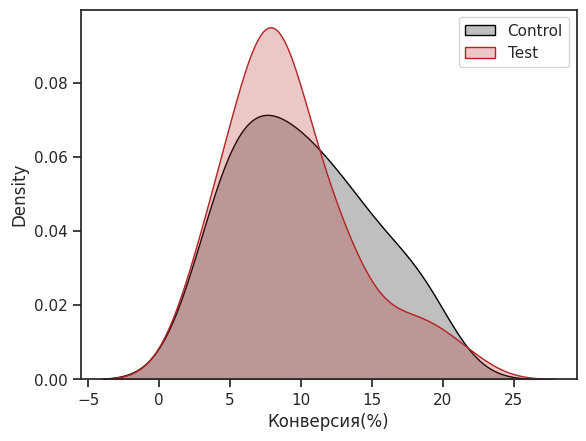

In [ ]:
sns.kdeplot(control_group, label="Control", fill = True, color = '#000000')
sns.kdeplot(test_group, label="Test", fill = True, color = '#B22222')
plt.legend()
plt.show()

In [ ]:
stat, p = st.shapiro(test_group)

print(f"Статистика = {stat:.5f}, p = {p:.5f}")
if p > 0.05:
    print('Вероятно нормальное распределение')
else:
    print('Вероятно не нормальное распределение')

Статистика = 0.92547, p = 0.03726
Вероятно не нормальное распределение


In [ ]:
stat, p = st.shapiro(control_group)

print(f"Статистика = {stat:.5f}, p = {p:.5f}")
if p > 0.05:
    print('Вероятно нормальное распределение')
else:
    print('Вероятно не нормальное распределение')

Статистика = 0.94742, p = 0.17053
Вероятно нормальное распределение


Используем критерий Манна-Уитни.

In [ ]:
stat, p = st.mannwhitneyu(control_group, test_group)

print(f"Статистика = {stat:.5f}, p = {p:.5f}")

if p > 0.05:
    print('Не отклоняем нулевую гипотезу, разницы, вероятно, нет')
else:
    print('Отклоняем нулевую гипотезу, разница, вероятно, есть')

Статистика = 463.50000, p = 0.50341
Не отклоняем нулевую гипотезу, разницы, вероятно, нет


<b>Вывод.</b> Тест не показал наличие статистически значимой разницы в конверсии. На основе трех проведенных исследований можно утверждать, что новая кампания не позволяет улучшить показатели ни по одному из трех критериев.